In [1]:
!python3 --version


**Install requirements**

In [ ]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import models and utils from github**



In [2]:
import os

if not os.path.isdir('./models'):
  !git clone https://github.com/robertofranceschi/Domain-adaptation-on-PACS-dataset.git
  !cp -r "/content/Domain-adaptation-on-PACS-dataset/code/models" "/content/"
  !cp -r "/content/Domain-adaptation-on-PACS-dataset/code/utils" "/content/"

**Import libraries**

In [1]:
import sys
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from models.models import *
from utils.utils import *

**Set Arguments**

In [2]:
DEVICE = 'cuda'      # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 7 classes for each domain: 'dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'
DATASETS_NAMES = ['photo', 'art', 'cartoon', 'sketch']
CLASSES_NAMES = ['Dog', 'Elephant', 'Giraffe', 'Guitar', 'Horse', 'House', 'Person']

# HYPERPARAMETER -------------------
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 5
# ----------------------------------

# Hyperparameters for grid search
BATCH_SIZE = 128      # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                      # the batch size, learning rate should change by the same factor to have comparable results
LR = 1e-4             # The initial Learning Rate
NUM_EPOCHS = 30       # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20        # How many epochs before decreasing learning rate (if using a step-down policy)
MODE = '4C'           # '3A', '3B', '4A', '4C'
ALPHA = 1.            # alpha
ALPHA_EXP = False

EVAL_ACCURACY_ON_TRAINING = False
SHOW_IMG = True       # if 'True' show images and graphs on output
SHOW_RESULTS = True   # if 'True' show images and graphs on output

**Define Data Preprocessing**

In [3]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose([ #transforms.Resize(227),      # Resizes short size of the PIL image to 256
                              transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

# Define datasets root
DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


**Data exploration**

------ Some statistics ------
Total images: 9991
Number of classes: 7
Classes: [0 1 2 3 4 5 6]
Classes Names: ['Dog', 'Elephant', 'Giraffe', 'Guitar', 'Horse', 'House', 'Person']

Total images per class: [1729 1654 1566 1113 1540  943 1446]
Mean images per class: 1427.2857142857142
Std images per class: 269.4002408980333

Total images per domain/dataset:
Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929

Element per class for each domain:
photo_dataset: [189 202 182 186 199 280 432]
art_dataset: [379 255 285 184 201 295 449]
cartoon_dataset: [389 457 346 135 324 288 405]
sketch_dataset: [772 740 753 608 816  80 160]


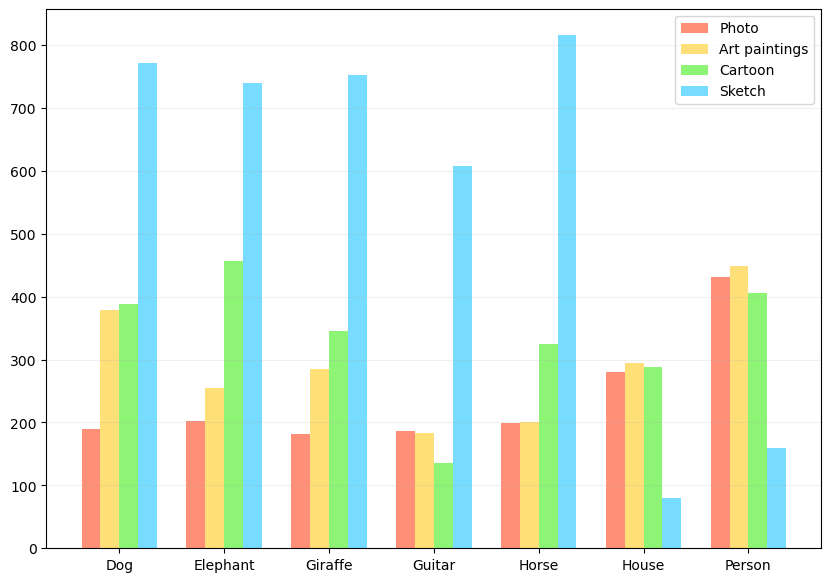

<Figure size 640x480 with 0 Axes>

In [9]:
photo_dataset.imgs # same of print(photo_dataset.samples)
# [('Homework3-PACS/PACS/photo/dog/056_0001.jpg', 0),
#  ('Homework3-PACS/PACS/photo/dog/056_0002.jpg', 0) ... ]

photo_dataset.classes
# 'dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'

photo_dataset.class_to_idx
# {'dog': 0,
#  'elephant': 1,
#  'giraffe': 2,
#  'guitar': 3,
#  'horse': 4,
#  'house': 5,
#  'person': 6}

# dimension of an image 3x227x227
torch.Size([3, 227, 227])

# plot images distribution
plotImageDistribution(photo_dataset.targets, art_dataset.targets, cartoon_dataset.targets, sketch_dataset.targets, DATASETS_NAMES, CLASSES_NAMES, show=SHOW_IMG)

**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

In [ ]:
# check dimensions of images
# cnt = 0
# for img, _ in dataloader :
#   print(img.shape)
#   cnt+=1
# print(cnt)

**Prepare Network for training**

In [6]:
cudnn.benchmark # Calling this optimizes runtime

if MODE == None :
  raise RuntimeError("Select a MODE")
elif MODE == '3A':
  # 3A) SENZA DANN
  USE_DOMAIN_ADAPTATION = False
  CROSS_DOMAIN_VALIDATION = False
  USE_VALIDATION = False
  ALPHA = None
  transfer_set = None
elif MODE == '3B' :
  # 3B) Train DANN on Photo and test on Art painting with DANN adaptation
  USE_DOMAIN_ADAPTATION = True
  USE_VALIDATION = False
  transfer_set = "art painting"
elif MODE == '4A':
  # 4A) Run a grid search on Photo to Cartoon and Photo to Sketch, without Domain Adaptation, and average results for each set of hyperparameters
  transfer_set = 'sketch' # Photo to 'cartoon' or 'sketch'
  USE_VALIDATION = True   # validation on transfer_set
  USE_DOMAIN_ADAPTATION = False
  CROSS_DOMAIN_VALIDATION = False
  ALPHA = None
  # 4B) when testing
elif MODE == '4C':
  # 4C) Run a grid search on Photo to Cartoon and Photo to Sketch, with Domain Adaptation, and average results for each set of hyperparameters
  USE_VALIDATION = True   # validation on transfer_set
  USE_DOMAIN_ADAPTATION = True
  CROSS_DOMAIN_VALIDATION = True
  # edit the following hyperparams:
  transfer_set = 'cartoon' # Photo to 'cartoon' or 'sketch'


EVAL_ACCURACY_ON_TRAINING = False
SHOW_RESULTS = True

source_dataloader = photo_dataloader
test_dataloader = art_dataloader

# Loading model
net = dann_net(pretrained=True).to(DEVICE)
#print(net) #check size output layer OK

# Define loss function: CrossEntrpy for classification
criterion = nn.CrossEntropyLoss()

# Choose parameters to optimize
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer: updates the weights based on loss (SDG with momentum)
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler -> step-down policy which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

if USE_DOMAIN_ADAPTATION and ALPHA == None :
  raise RuntimeError("To use domain adaptation you must define parameter ALPHA")

if transfer_set == 'cartoon':
  target_dataloader = cartoon_dataloader
elif transfer_set == 'sketch':
  target_dataloader = sketch_dataloader
else :
  target_dataloader = test_dataloader # art_dataloader

if ALPHA_EXP :
  # ALPHA exponential decaying as described in the paper
  p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
  ALPHA = 2. / (1. + np.exp(-10 * p)) - 1

**Train**

In [ ]:
current_step = 0
accuracies_train = []
accuracies_validation = []
loss_class_list = []
loss_target_list = []
loss_source_list = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):

  net.train(True)

  #print('--- Epoch {}/{}, LR = {}  ALPHA = [{}] TARGET DATASET = [{}]'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), ALPHA, transfer_set))
  print(f"--- Epoch {epoch+1}/{NUM_EPOCHS}, LR = {scheduler.get_last_lr()}")

  # Iterate over the dataset
  for source_images, source_labels in source_dataloader:
    source_images = source_images.to(DEVICE)
    source_labels = source_labels.to(DEVICE)

    optimizer.zero_grad() # Zero-ing the gradients

    # STEP 1: train the classifier
    outputs = net(source_images)
    loss_class = criterion(outputs, source_labels)
    loss_class_list.append(loss_class.item())

    # if current_step % LOG_FREQUENCY == 0:
    #   print('Step {}, Loss Classifier {}'.format(current_step+1, loss_class.item()))
    loss_class.backward()  # backward pass: computes gradients

    # Domain Adaptation (Cross Domain Validation)
    if USE_DOMAIN_ADAPTATION :

      # Load target batch
      target_images, target_labels = next(iter(target_dataloader))
      target_images = target_images.to(DEVICE)

      # if ALPHA_EXP :
      #   # ALPHA exponential decaying as described in the paper
      #   p = float(i + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
      #   ALPHA = 2. / (1. + np.exp(-10 * p)) - 1

      # STEP 2: train the discriminator: forward SOURCE data to Gd
      outputs = net.forward(source_images, alpha=ALPHA)
      # source's label is 0 for all data
      labels_discr_source = torch.zeros(BATCH_SIZE, dtype=torch.int64).to(DEVICE)
      loss_discr_source = criterion(outputs, labels_discr_source)
      loss_source_list.append(loss_discr_source.item())
      # if current_step % LOG_FREQUENCY == 0:
      #   print('Step {}, Loss Discriminator Source {}'.format(current_step+1, loss_discr_source.item()))
      loss_discr_source.backward()

      # STEP 3: train the discriminator: forward TARGET to Gd
      outputs = net.forward(target_images, alpha=ALPHA)
      labels_discr_target = torch.ones(BATCH_SIZE, dtype=torch.int64).to(DEVICE) # target's label is 1
      loss_discr_target = criterion(outputs, labels_discr_target)
      loss_target_list.append(loss_discr_target.item())
      # if current_step % LOG_FREQUENCY == 0:
        # print('Step {}, Loss Discriminator Target {}'.format(current_step+1, loss_discr_target.item()))
      loss_discr_target.backward()    #update gradients

    optimizer.step() # update weights based on accumulated gradients

  # --- Accuracy on training
  if EVAL_ACCURACY_ON_TRAINING:
    with torch.no_grad():
      net.train(False)

      running_corrects_train = 0

      for images_train, labels_train in source_dataloader:
        # images, labels = next(iter(source_dataloader))
        images_train = images_train.to(DEVICE)
        labels_train = labels_train.to(DEVICE)

        # Forward Pass
        outputs_train = net(images_train)

        # Get predictions
        _, preds = torch.max(outputs_train.data, 1)

        # Update Corrects
        running_corrects_train += torch.sum(preds == labels_train.data).data.item()

    # Calculate Accuracy
    accuracy_train = running_corrects_train / float(len(source_dataloader)*(target_dataloader.batch_size))
    accuracies_train.append(accuracy_train)
    print('Accuracy on train (photo):', accuracy_train)

  # --- VALIDATION SET
  if USE_VALIDATION :
    # now train is finished, evaluate the model on the target dataset
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in target_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = net(images)
      _, preds = torch.max(outputs.data, 1)
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float( len(target_dataloader)*(target_dataloader.batch_size) )
    accuracies_validation.append(accuracy)
    print(f"Accuracy on validation ({transfer_set}): {accuracy}")

  # Step the scheduler
  current_step += 1
  scheduler.step()

if SHOW_RESULTS:
  print()
  print("Loss classifier")
  print(loss_class_list)
  if USE_DOMAIN_ADAPTATION :
    print("\nLoss discriminator source")
    print(loss_source_list)
    print("\nLoss discriminator target")
    print(loss_target_list)

--- Epoch 1/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.2565789473684211
--- Epoch 2/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.26069078947368424
--- Epoch 3/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.23766447368421054
--- Epoch 4/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.234375
--- Epoch 5/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.24753289473684212
--- Epoch 6/30, LR = [0.0001]
Accuracy on validation (cartoon): 0.2565789473684211
--- Epoch 7/30, LR = [0.0001]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022FB51FDAF0>
Traceback (most recent call last):
  File "c:\Users\TingNobody\.conda\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\TingNobody\.conda\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\TingNobody\.conda\envs\pytorch\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\TingNobody\.conda\envs\pytorch\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataset))

print('\nTest Accuracy (art painting): {} ({} / {})'.format(accuracy, running_corrects, len(art_dataset)))

100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Test Accuracy (art painting): 0.48876953125 (1001 / 2048)


In [ ]:
beep()
if USE_VALIDATION :
  print(f"Validation on:  {transfer_set}")
  print(f"accuracy_valid: {accuracies_validation[-1]:.4f}")
print(f"Test accuracy:  {accuracy:.4f}")
print(f"Val on {transfer_set}, LR = {LR}, ALPHA = {ALPHA}, BATCH_SIZE = {BATCH_SIZE}")
print(accuracies_validation)

Validation on:  cartoon
accuracy_valid: 0.4017
Test accuracy:  0.4888
Val on cartoon, LR = 0.0001, ALPHA = 1.0, BATCH_SIZE = 128
[0.24259868421052633, 0.2680921052631579, 0.26274671052631576, 0.3013980263157895, 0.3227796052631579, 0.33758223684210525, 0.34745065789473684, 0.3490953947368421, 0.34539473684210525, 0.35567434210526316, 0.3638980263157895, 0.36883223684210525, 0.3754111842105263, 0.3737664473684211, 0.3754111842105263, 0.37417763157894735, 0.37582236842105265, 0.37787828947368424, 0.38651315789473684, 0.3918585526315789, 0.3930921052631579, 0.3939144736842105, 0.39555921052631576, 0.3951480263157895, 0.39432565789473684, 0.3959703947368421, 0.39679276315789475, 0.39925986842105265, 0.40131578947368424, 0.4017269736842105]


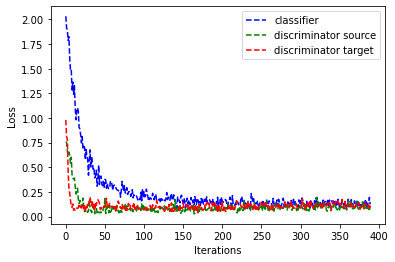

In [ ]:
if USE_DOMAIN_ADAPTATION :
  # Plot losses
  plotLosses(loss_class_list, loss_source_list, loss_target_list, n_epochs=len(loss_class_list), show=SHOW_IMG)